# Capstone project: Traffic Signs classification


The goal of this notebook is to study the performance of different machine learning methods for the traffic signs classification task. All the necessary functions to read the training and test data are also provided. <br>
The original dataset can be downloaded from: http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset.

#### Import libraries

In [1]:
#Import necessary libraries
import matplotlib.pyplot as plt
import csv
import numpy as np
from numpy.random import randn
import os, random
import pandas as pd

# Import the stats library from numpy
from scipy import stats

# These are the plotting modules adn libraries we'll use:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Command so that plots appear in the iPython Notebook
%matplotlib inline

### Read trining images and corresponding labels

In [45]:
# Sample code for reading the traffic sign images and the
# corresponding labels. This is a modificated version of the code provided here:
# http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset#Codesnippets

# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 43 classes
    for c in range(0,43):    
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        
        #print (prefix)
        
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        
        #print (gtFile)
        
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        #gtReader.next() # skip header Python 2
        next(gtReader) # skip header Python 3
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(np.int(row[7]))# the 8th column is the label
        gtFile.close()
    return images, np.array(labels)

In [46]:
#Read the training images and their corresponding labels
rootpath = './GTSRB/Final_Training/Images'
images, labels = readTrafficSigns(rootpath)

In [4]:
print('Number of training images: ', len(labels))

Number of training images:  39209


In [5]:
print('Number of classes: ', len(np.unique(labels)))

Number of classes:  43


In [6]:
print('Number of itraining mages per class: \n',np.bincount(labels))

Number of itraining mages per class: 
 [ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160  780
  630  420 1110 1200  210  360  330  390  510  270 1500  600  240  540  270
  450  780  240  689  420 1200  390  210 2070  300  360  240  240]


 ### Read features from HDF5 file

In [4]:
# Read data from hdf5 files

import tables

hdf5_path = "capstone_project_data.hdf5"
read_hdf5_file = tables.open_file(hdf5_path, mode='r')

HOG = read_hdf5_file.root.HOG[:]
HAAR = read_hdf5_file.root.HAAR[:]
HUE = read_hdf5_file.root.HUE[:]

read_hdf5_file.close()

In [9]:
print('----Features size----')
print('HOG: ', HOG.shape)
print('HAAR: ', HAAR.shape)
print('HUE: ', HUE.shape)

----Features size----
HOG:  (39209, 6052)
HAAR:  (39209, 11584)
HUE:  (39209, 256)


In [27]:
# Separate HOG features
HOG1 = HOG[:,0:1568]
HOG2 = HOG[:,1568:1568*2]
HOG3 = HOG[:,1568*2:]

print('----HOG arrays size----')
print('HOG1: ', HOG1.shape)
print('HOG2: ', HOG2.shape)
print('HOG3: ', HOG3.shape)

----HOG arrays size----
HOG1:  (39209, 1568)
HOG2:  (39209, 1568)
HOG3:  (39209, 2916)


### Generate training features matrix

In [5]:
X_train = np.column_stack((HOG,HAAR))
del HOG, HAAR #free memory
X_train = np.column_stack((X_train,HUE))
del HUE

In [101]:
print('Features matrix size: ',X_train.shape)

Features matrix size:  (39209, 17892)


### Appy PCA for feature selection

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

n_comp =50
pca_trafo = PCA(n_components=n_comp)

# PCA: To prevent those few dimensions from dominanting the PCA it is highly suggested to 
# normalize the data using z-scaling. 
# This can be done in sklearn
z_scaler = StandardScaler()
z_data = z_scaler.fit_transform(X_train)

pca_data = pca_trafo.fit_transform(z_data)
pca_inv_data = pca_trafo.inverse_transform(np.eye(n_comp))

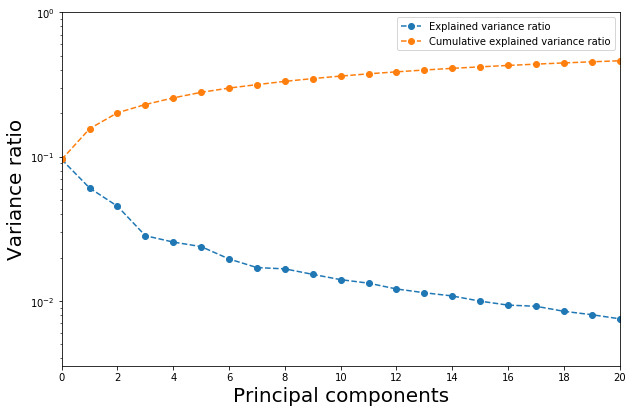

In [73]:
import sklearn.datasets as ds

fig = plt.figure(figsize=(10, 6.5))
plt.semilogy(pca_trafo.explained_variance_ratio_, '--o', label='Explained variance ratio');
plt.semilogy(pca_trafo.explained_variance_ratio_.cumsum(), '--o', label='Cumulative explained variance ratio');
plt.xlim([0,20])
plt.xticks(np.arange(0, 22,2))
plt.ylim([0,1])
plt.xlabel('Principal components', fontsize=20)
plt.ylabel('Variance ratio', fontsize=20)
plt.legend()

Looking at the explained variance ratio and its cumulative version, the variances slope are almost linear in logarithmic scale. According to the cumulative explained variance it seems that by keeping only 20 principal components we can more than the 80% of the full variance.<br>
With this we drastically reduced the size of the feature space while compromising only 20% of potential information.

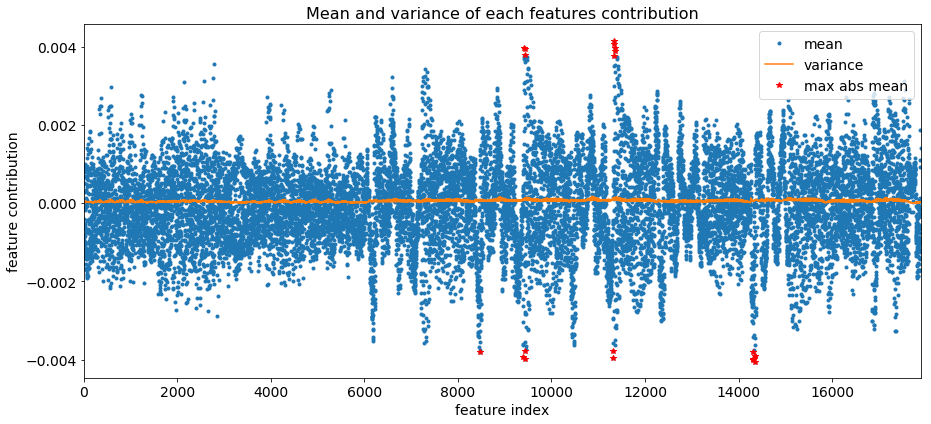

In [9]:
fig = plt.figure(figsize=(15, 6.5))

pca_mean = pca_inv_data.mean(axis=0)
pca_std = np.square(pca_inv_data.std(axis=0))
plt.plot(pca_mean, '.',label = 'mean')
plt.plot(pca_std, label = 'variance')

# Find 100 indexes of N maximum values in mean array
arr = np.abs(pca_mean)
indices = arr.argsort()[-20:][::-1]
plt.plot(indices,pca_mean[indices], '*', color='red', label='max abs mean')

plt.legend(loc='lower right')
plt.ylabel('feature contribution', fontsize=14);
plt.xlabel('feature index', fontsize=14);
plt.tick_params(axis='both', which='major', labelsize=14);
plt.tick_params(axis='both', which='minor', labelsize=14);
plt.xlim([0, len(pca_mean)])
plt.legend(loc='upper right', fontsize=14)
plt.title('Mean and variance of each features contribution', fontsize=16)

In [10]:
# Only keep features with large absolute mean and see how those perform in a modeling task.
arr = np.abs(pca_mean)
indices = arr.argsort()[-20:][::-1]

features_pca = X_train[:,indices]

### Save PCA fefatures in a hdf5 file

In [12]:
import tables

hdf5_path = "capstone_project_features_pca.hdf5"
hdf5_file = tables.open_file(hdf5_path, mode='w') # writing mode
data_storage = hdf5_file.create_array(hdf5_file.root, 'features_pca', features_pca)

hdf5_file.close()

### Read PCA components from a hdf5 file

In [13]:
hdf5_path = "capstone_project_features_pca.hdf5"
read_hdf5_file = tables.open_file(hdf5_path, mode='r')

features_pca = read_hdf5_file.root.features_pca[:]
read_hdf5_file.close()

### Read Test data

In [26]:
# function for reading the test images
# arguments: path to the traffic sign data, for example './GTSRB/Test'
# returns: list of images, list of corresponding labels 
def readTestTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Test'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
     
    #Read images and labels (all from the same file)       
    gtFile = open(rootpath + '/' + 'GT-final_test.csv') # annotations file               
        
    gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
    next(gtReader) # skip header Python 3
    
    # loop over all rows in annotations file
    for row in gtReader:
        #images.append(plt.imread(rootpath + '/' + 'Images' + '/' + row[0])) # the 1th column is the filename
        labels.append(np.int(row[7])) # the 8th column is the label
    gtFile.close()     
        
    return images, np.array(labels)

In [27]:
#Read the test images 
rootpath = './GTSRB/Final_Test'
images_test, labels_test = readTestTrafficSigns(rootpath)

In [20]:
# Read data from hdf5 files

import tables

hdf5_path = "capstone_project_test_data.hdf5"
read_hdf5_file = tables.open_file(hdf5_path, mode='r')

HOG_test = read_hdf5_file.root.HOG_test[:]
HAAR_test = read_hdf5_file.root.HAAR_test[:]
HUE_test = read_hdf5_file.root.HUE_test[:]

read_hdf5_file.close()

In [41]:
import tables

hdf5_path = "capstone_project_test_data.hdf5"
read_hdf5_file = tables.open_file(hdf5_path, mode='r')

HOG_test = read_hdf5_file.root.HOG_test[:]
HOG2_test = HOG_test[:,1568:1568*2]

In [21]:
X_test = np.column_stack((HOG_test,HAAR_test))
del HOG_test, HAAR_test #free memory
X_test = np.column_stack((X_test,HUE_test))
del HUE_test

In [60]:
X_pca_test = np.column_stack((HOG_pca_test,HAAR_pca_test))
X_pca_test = np.column_stack((X_pca_test,HUE_pca_test))
del HOG_pca_test, HAAR_pca_test, HUE_pca_test
X_pca_test.shape

(12630, 300)

In [23]:
print('Test features matrix size: ',X_test.shape)

Test features matrix size:  (12630, 17892)


### Test data feature selection

In [24]:
# Test data feature selection

# Only keep features with large absolute mean.
# indices array has been computed from training data
features_pca_test = X_test[:,indices]

### PCA features

In [28]:
X_train_pca = features_pca
y_train = labels


X_test_pca = features_pca_test
y_test = labels_test

### Standardize features

In [42]:
# Standardizing the features so that they are centered around 0 with 
# a standard deviation of 1 is important when comparing measurements that have different units.
# It is also a general requirement for many machine learning algorithms. 

X_train = HOG2
y_train = labels

X_test = HOG2_test
y_test = labels_test

z_scaler = StandardScaler()
X_train = z_scaler.fit_transform(X_train)
X_test  = z_scaler.fit_transform(X_test)

### Linear Discriminant Analysis

In [13]:
# Perform LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

clf_lda = LinearDiscriminantAnalysis()

clf_lda.fit(X_train, y_train)

# Print the accuracy from the training data.
print('LDA model on HOG2 training data:  ', accuracy_score(clf_lda.predict(X_train), y_train))

LDA model on HOG2 training data:   0.989619730164


In [21]:
# Print the accuracy from the test data.
print('LDA model on HOG2 test data:  ', accuracy_score(clf_lda.predict(X_test), y_test))

LDA model on HOG2 test data:   0.956848772763


### LDA Confusion Matrix

C:\Users\uidm1500\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


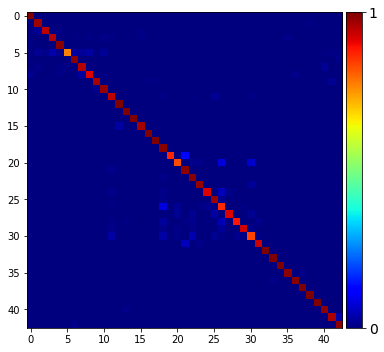

In [71]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

###Confusion matrix with sklearn
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
conf_arr = confusion_matrix(clf_lda.predict(X_test), labels_test)

norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)   
    

plt.figure(figsize=(6, 6))
ax = plt.gca()
im = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax,ticks=[0,1]) 
#plt.colorbar(im) 

alphabet = range(0,43)
plt.xticks(range(width), alphabet[:width], fontsize=14)
plt.yticks(range(height), alphabet[:height], fontsize=14)
plt.savefig('confusion_matrix.png', format='png')    

## Logistic Regression

#### Find optimal parameters

In [96]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 3
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 3 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [37]:
#the grid of parameters to search over
Cs = [0.01, 1, 10]

score_list=[]
for C in Cs:
    clf = LogisticRegression(C=C)
    
    # Fit the model on the trainng data.
    clf.fit(X_train, y_train)
    
    current_score = cv_score(clf, X_train, y_train)
    score_list.append(current_score)
    
    print('C: ', C,'score: ', current_score)

  
max_score = max(score_list)         #Highest average score 
C_max_score = Cs[score_list.index(max_score)] 
print ('')
print ('C value for max score: ', C_max_score)  #Pick the C with the highest average score  


C value for max score:  10


### Logistic Regression on PCA features

In [32]:
from sklearn.linear_model import LogisticRegression

clf_LR = LogisticRegression()

# Fit the model on the trainng data.
clf_LR.fit(X_train_pca, y_train)

# Print the accuracy from the training data.
print('Logistic regresion model on training PCA features:  ', accuracy_score(clf_LR.predict(X_train_pca), y_train))

Logistic regresion model on training PCA features:   0.118646229182


In [33]:
# Print the accuracy from the training data.
print('Logistic regresion model on test PCA features:  ', accuracy_score(clf_LR.predict(X_test_pca), y_test))

Logistic regresion model on test PCA features:   0.106334125099


### Logistic Regression on HOG2 features

In [29]:
clf_LR = LogisticRegression(C=C_max_score)

X_train = HOG2
y_train = labels

# Fit the model on the trainng data.

clf_LR.fit(X_train, y_train)

# Print the accuracy from the training data.
print('Logistic regresion model on HOG2:  ', accuracy_score(clf_LR.predict(X_train), y_train))

Logistic regresion model on PCA:   0.998928817363


In [37]:
# Print the accuracy from the testing data.

print('Logistic regresion model on HOG2:  ', accuracy_score(clf_LR.predict(X_test), y_test))

Logistic regresion model on PCA:   0.956452889945


### Random Forest on PCA components

In [37]:
# Try the model
#from read import readTrafficSigns,readTestSigns
from sklearn.ensemble import RandomForestClassifier
import numpy as np

X_train = X_pca
y_train = labels

clf_random_forests = RandomForestClassifier()
clf_random_forests.fit(X_train, y_train)


print('Random Forest PCA accuracy on training data:  ', accuracy_score(clf_random_forests.predict(X_train), y_train))

Random Forest PCA accuracy on training data:   0.999311382591


In [61]:
# Test 

y_test = labels_test

print('Random Forest PCA accuracy on test data:  ', accuracy_score(clf_random_forests.predict(X_pca_test), y_test))

Random Forest PCA accuracy on test data:   0.198495645289


### Random Forest on HOG2

In [137]:
# Try the model
#from read import readTrafficSigns,readTestSigns
from sklearn.ensemble import RandomForestClassifier
import numpy as np

X_train = HOG2
y_train = labels


#t = RandomForestClassifier(n_estimators=300,max_features = 100, min_samples_split =100, oob_score = True)
clf_random_forests = RandomForestClassifier(n_estimators=300,max_features = 100, min_samples_split =100)
clf_random_forests.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=100, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [138]:
print('Random Forest HOG2 accuracy on training data:  ', accuracy_score(clf_random_forests.predict(X_train), y_train))

Random Forest HOG2 accuracy on training data:   0.996301869469


In [139]:
# Test 

X_test = HOG2_test
y_test = labels_test

print('Random Forest HOG2 accuracy on test data:  ', accuracy_score(clf_random_forests.predict(X_test), y_test))

Random Forest HOG2 accuracy on test data:   0.96017418844


### Suport Vector Machines

#### SVM on PCA features

In [62]:
from sklearn import svm

# SVC implements the “one-against-one” approach (Knerr et al., 1990) for multi- class classification.
clf_SVM = svm.SVC()
clf_SVM.fit(X_pca, y_train)  

print('SVM PCA accuracy on training data:  ', accuracy_score(clf_SVM.predict(X_pca), y_train))

SVM PCA accuracy on training data:   1.0


In [63]:
print('SVM PCA accuracy on test data:  ', accuracy_score(clf_SVM.predict(X_pca_test), y_test))

SVM PCA accuracy on test data:   0.0593824228029


### SVM on (non-standardized) HOG2 features

In [38]:
# SVC implements the “one-against-one” approach (Knerr et al., 1990) for multi- class classification.
from sklearn import svm

X_train = HOG2
y_train = labels

clf_SVM = svm.SVC()
clf_SVM.fit(X_train, y_train)  

print('SVM HOG2 accuracy on training data:  ', accuracy_score(clf_SVM.predict(X_train), y_train))

SVM HOG2 accuracy on training data:   0.851258639598


In [39]:
print('SVM HOG2 accuracy on test data:  ', accuracy_score(clf_SVM.predict(X_test), y_test))

SVM HOG2 accuracy on test data:   0.809263657957


### SVM on standardized HOG2 features

In [43]:
# SVC implements the “one-against-one” approach (Knerr et al., 1990) for multi- class classification.
from sklearn import svm

clf_SVM = svm.SVC()
clf_SVM.fit(X_train, y_train)  

print('SVM HOG2 accuracy on training data:  ', accuracy_score(clf_SVM.predict(X_train), y_train))

SVM HOG2 accuracy on training data:   0.999897982606


In [44]:
print('SVM HOG2 accuracy on test data:  ', accuracy_score(clf_SVM.predict(X_test), y_test))

SVM HOG2 accuracy on test data:   0.950118764846
